# MHD Pinn

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

In [2]:
print(torch.get_num_threads())
print(torch.get_num_interop_threads())

6
6


## Functions

In [228]:
# we're training and recording losses. stopping criteria, for a given point, if the next 5 steps don't improve the loss over some
# some tolerance (perhaps absolute value)
# pytorch lightning

In [3]:
def calculate_similarity_metrics(grads1, grads2):
    grads1_flat = torch.cat([g.flatten() for g in grads1])
    grads2_flat = torch.cat([g.flatten() for g in grads2])
    
    cos_sim = cosine_similarity(grads1_flat.numpy().reshape(1, -1), grads2_flat.numpy().reshape(1, -1))[0,0]
    euc_dist = euclidean(grads1_flat, grads2_flat)
    
    return cos_sim, euc_dist

In [4]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1) # Recursively take gradients
    else:
        return outputs

In [5]:
def initial_condition(x):
    condition1 = torch.tensor([1.0,0.0,0.0,0.0,1.0,0.0,1.0])
    condition2 = torch.tensor([0.125,0.0,0.0,0.0,-1.0,0.0,0.1])
    newx = torch.flatten(x)
    return torch.outer(newx<0, condition1) + torch.outer(newx>=0, condition2)

In [6]:
def conserved(P): #f_u(P)
    t_P = P.t().squeeze()
    rho = t_P[0]
    vx = t_P[1]
    vy = t_P[2]
    vz = t_P[3]
    By = t_P[4]
    Bz = t_P[5]
    p = t_P[6]

    rhovx = vx*rho
    rhovy = vy*rho
    rhovz = vz*rho

    energy = (p/(gamma-1) + 1/2*(Bx**2+By**2+Bz**2) + rho/2*(vx**2+vy**2+vz**2))

    return torch.stack((rho, rhovx, rhovy, rhovz, By, Bz, energy)).t()
    #return torch.tensor(P)
    
    

def current(P): # J(P)
    t_P = P.t().squeeze()
    rho = t_P[0]
    vx = t_P[1]
    vy = t_P[2]
    vz = t_P[3]
    By = t_P[4]
    Bz = t_P[5]
    p = t_P[6]

    rhovx = vx*rho

    ps = p + 1/2*(Bx**2+By**2+Bz**2)
    energy = (p/(gamma-1) + 1/2*(Bx**2+By**2+Bz**2) + rho/2*(vx**2+vy**2+vz**2))

    return torch.stack((
        rhovx, 
        rhovx**2 + ps -Bx**2, 
        rhovx*vy - Bx*By, 
        rhovx*vz - Bx*Bz, 
        By*vx - Bx*vy, 
        Bz*vx - Bx*vz, 
        (energy+ps)*vx - Bx*(Bx*vx+By*vy+Bz*vz)
    )).t()

## Hyperparameters

In [270]:
# Hyperparameters
depth = 5
width = 100
#make the model bigger and add residual connections
# 100 wide hidden layers
lr = 0.001
num_epochs = 10000
activation = nn.Tanh()

#model parameter
gamma = 2.0
Bx = 0.75

## Define Neural Network

### Residual Neural Network

In [7]:
class ResPINN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=5, hidden_width=100, activation=nn.Tanh()):
        super().__init__()
        self.layers = nn.ModuleList()
        layer_dims = [input_size, *(n_hidden*[hidden_width]), output_size]
        for i, j in zip(layer_dims, layer_dims[1:]):
            self.layers.append(nn.Linear(i, j))
        self.activation = activation

    def forward(self, x):
        out = self.activation(self.layers[0](x))
        for layer in self.layers[1:-1]:
            out = self.activation(layer(out) + out)
        out = self.activation(self.layers[-1](out))
        return out

### Standard PINN

In [8]:
def init_xavier(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)

def init_glorot_normal(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=2/(module.in_features + module.out_features))

class PINN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=5, hidden_width=100, activation=nn.Tanh(), res=True):
        super(PINN, self).__init__()
        self.activation = activation
        if res: 
            self.net = ResPINN(input_size, output_size, n_hidden, hidden_width, activation)
        else: 
            layers = nn.ModuleList()
            layer_dims = [input_size, *(n_hidden*[hidden_width])]
            for i, j in zip(layer_dims, layer_dims[1:]):
                layers.append(nn.Linear(i, j))
                layers.append(activation)
            layers.append(nn.Linear(layer_dims[-1], output_size))
            self.net = nn.Sequential(*layers)
            self.net.apply(init_glorot_normal)
        
    def forward(self, t, x):
        t = t.unsqueeze(1) if len(t.shape) == 1 else t
        x = x.unsqueeze(1) if len(x.shape) == 1 else x
        X = torch.cat([x, t], dim=1)
        u = self.net(X)
        return u


In [9]:
def mhd_residual(pred,t,x):
    u_t= gradients(conserved(pred),t)
    u_x= gradients(current(pred),x)
    return u_t + u_x


def random_domain(num_samples, t_range, x_range):
    t_random = torch.zeros(size=(num_samples, 1)).uniform_(*t_range)
    x_random = torch.zeros(size=(num_samples, 1)).uniform_(*x_range)
    t_random.requires_grad = True
    x_random.requires_grad = True
    return t_random, x_random

def random_boundary(num_samples, t_range, x_range, initial_to_boundary_ratio = 0.5):
    num_initial = int(initial_to_boundary_ratio * num_samples)
    num_boundary = num_samples - num_initial
    t_min, t_max = t_range

    # Generate initial condition samples
    t_initial = torch.zeros(size=(num_initial, 1))
    x_initial = torch.zeros(size=(num_initial, 1)).uniform_(*x_range)
    u_initial = initial_condition(x_initial)

    # Generate boundary condition samples
    t_boundary = torch.zeros(size=(num_boundary, 1)).uniform_(*t_range)

    # We assume x_range = (-1, 1) here
    x_boundary = 2 * torch.randint(0, 2, size=(num_boundary, 1)) - 1
    u_boundary = initial_condition(x_boundary)#np.zeros((num_boundary, 1))

    return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
           torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)
    

### Transformer from paper

In [ ]:
class TrainableTanh(nn.Module):
    def __init__(self):
        super(TrainableTanh, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))  

    def forward(self, x):
        return torch.tanh(self.beta * x)

# 2. Custom Neural Network
class CustomPINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(CustomPINN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define linear layers
        self.layers = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),  # U layer
            nn.Linear(input_dim, hidden_dim),  # V layer
            *[nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers)],  # hidden layers
            nn.Linear(hidden_dim, output_dim)  # output layer
        ])
        
        # Define activation function
        self.phi = TrainableTanh()
        
    def forward(self, x):
        U_t = self.phi(self.layers[0](x))
        V_t = self.phi(self.layers[1](x))
        H = U_t  # initial value for H
        
        for i in range(2, 2+self.num_layers):
            Z = self.phi(self.layers[i](H))
            H = (1 - Z) * U_t + Z * V_t
        
        output = self.layers[-1](H)
        return output

# 3. Initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Example Usage
input_dim = 2  # (x, t)
output_dim = 7  # Plasma state vector U = (ρ, vx, vy, vz, P, Bx, By, Bz)
hidden_dim = 64
num_layers = 5

model = CustomPINN(input_dim, output_dim, hidden_dim, num_layers)
model.apply(init_weights)  # Applying the weight initialization

# Example input
x_example = torch.randn(10, input_dim)  # 10 samples, each with 2 features (x, t)

# Forward pass
output = model(x_example)


### Sanity Check

In [13]:
# random_boundary sanity check
num_samples = 100
rb = random_boundary(num_samples,[0,1],[-1,1])

/var/folders/dh/9110858j7j59173xsmt5cm2c0000gn/T/ipykernel_3370/2823906431.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
/var/folders/dh/9110858j7j59173xsmt5cm2c0000gn/T/ipykernel_3370/2823906431.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)


## Initialize Model

In [271]:
model = PINN(input_size=2, output_size=7, n_hidden=depth, hidden_width=width, activation=activation, res=True)
# Decrease momentum
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.99, 0.999),weight_decay=0.001)
boundary_criterion = nn.MSELoss()
initial_criterion = nn.MSELoss()
domain_criterion = nn.MSELoss()

## Loading in a model

In [15]:
loaded_model = PINN(input_size=2, output_size=7)

In [22]:
loaded = torch.load('model_width_20_depth_14.pth')
loaded_model.load_state_dict(loaded)

<All keys matched successfully>

In [23]:
print(loaded_model)

PINN(
  (activation): Tanh()
  (net): ResPINN(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1-4): 4 x Linear(in_features=100, out_features=100, bias=True)
      (5): Linear(in_features=100, out_features=7, bias=True)
    )
    (activation): Tanh()
  )
)


In [24]:
for name, param in loaded_model.named_parameters():
     print(name, param)

net.layers.0.weight Parameter containing:
tensor([[-2.0591e-02, -1.0593e-03],
        [ 2.7773e-02, -1.3498e-02],
        [-4.0342e-01, -3.1990e-01],
        [-1.9521e-01,  2.5421e-01],
        [ 2.4117e-02,  8.7449e-03],
        [-1.9494e-01, -1.4171e-01],
        [-3.8250e-01, -3.7719e-02],
        [ 4.0313e-02,  1.8365e-02],
        [ 2.3431e-02, -5.3438e-02],
        [ 1.2270e-01, -3.9621e-02],
        [ 1.8047e-01,  2.3356e-02],
        [-5.2828e-02, -3.9496e-03],
        [-2.4245e-01, -1.1702e-01],
        [ 7.6990e-02,  3.4955e-02],
        [ 1.5583e-01,  2.5753e-02],
        [-2.0710e-01, -1.1233e-02],
        [ 3.7917e-02, -4.8568e-02],
        [-7.5043e-02, -1.4801e-01],
        [-2.2086e-01,  1.1966e-01],
        [ 4.9366e-02,  3.3234e-03],
        [-3.2911e-01, -5.2588e-02],
        [ 1.8271e-01,  9.8941e-02],
        [-3.7658e-01,  3.0264e-02],
        [-1.6884e-01,  2.1760e-02],
        [ 2.9400e-01, -3.5177e-02],
        [-3.9630e-01, -9.3698e-02],
        [-3.8686e-02, 

## Train Model

In [272]:
model.train()

x_range, t_range = [-1, 1], [0, 1]
loss_history = []
domain_loss_history = []
initial_loss_history = []
boundary_loss_history = []
a_history = []
b_history = []
c_history = []
gradient_history = []

for epoch in range(1, num_epochs + 1):
    domain_samples = 10000  # You can change this value
    boundary_samples = 100  # You can change this value

    optimizer.zero_grad()
    
    domain_t, domain_x = random_domain(domain_samples, t_range, x_range)
    initial_t, initial_x, initial_u, boundary_t, boundary_x, boundary_u = random_boundary(boundary_samples, t_range, x_range, 0.5)

    domain_prediction = model(domain_t, domain_x)
    domain_residual = mhd_residual(domain_prediction, domain_t, domain_x)
    initial_prediction = model(initial_t, initial_x)
    boundary_prediction = model(boundary_t, boundary_x)

    domain_loss = domain_criterion(domain_residual, torch.zeros_like(domain_residual))
    initial_loss = initial_criterion(initial_prediction, initial_u)
    boundary_loss = boundary_criterion(boundary_prediction, boundary_u)

    # domain_loss.backward
    # max value and divide by average gradient size approximately–take look at paper
    
    #increase the constant multiplier of domain_loss/boundary or IC loss 100 or 10
    #experiment
#     loss = model.a * domain_loss + model.b * initial_loss + model.c * boundary_loss # try scaling differntly
# weight the coefficients with respect to the gradients
    loss = domain_loss + 2*(initial_loss + boundary_loss)
    loss.backward()
    optimizer.step()
    
    current_grads = [p.grad.clone() for p in model.parameters()]
    gradient_history.append(current_grads)
    
    loss_history.append(loss.item())
    domain_loss_history.append(domain_loss.item())
    initial_loss_history.append(initial_loss.item())
    boundary_loss_history.append(boundary_loss.item())

    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

/var/folders/vy/754_vdn134g149mlnxys8r_80000gn/T/ipykernel_3835/2823906431.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
/var/folders/vy/754_vdn134g149mlnxys8r_80000gn/T/ipykernel_3835/2823906431.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)


Epoch: 100, Loss: 0.09733562171459198
Epoch: 200, Loss: 0.06554532796144485
Epoch: 300, Loss: 0.032496385276317596
Epoch: 400, Loss: 0.01640031673014164
Epoch: 500, Loss: 0.00629016850143671
Epoch: 600, Loss: 0.004073565825819969
Epoch: 700, Loss: 0.006754497531801462
Epoch: 800, Loss: 0.0011518975952640176
Epoch: 900, Loss: 0.002665296196937561
Epoch: 1000, Loss: 0.0011929809115827084
Epoch: 1100, Loss: 0.0014108233153820038
Epoch: 1200, Loss: 0.0071916719898581505
Epoch: 1300, Loss: 0.013630894012749195
Epoch: 1400, Loss: 0.009459028951823711
Epoch: 1500, Loss: 0.0011407567653805017
Epoch: 1600, Loss: 0.003927433397620916
Epoch: 1700, Loss: 0.007090700324624777
Epoch: 1800, Loss: 0.008402220904827118
Epoch: 1900, Loss: 0.005824449937790632
Epoch: 2000, Loss: 0.006664643995463848
Epoch: 2100, Loss: 0.005685570649802685
Epoch: 2200, Loss: 0.04205739125609398
Epoch: 2300, Loss: 0.0255801472812891
Epoch: 2400, Loss: 0.0074638728983700275
Epoch: 2500, Loss: 0.02177000418305397
Epoch: 2600

### Save Model

In [264]:
os.makedirs('models', exist_ok=True)

# Assuming width and depth are integers.
model_name = f'model_width_{width}_depth_{depth}.pth'

torch.save(model.state_dict(), os.path.join('models', model_name))


## Plotting

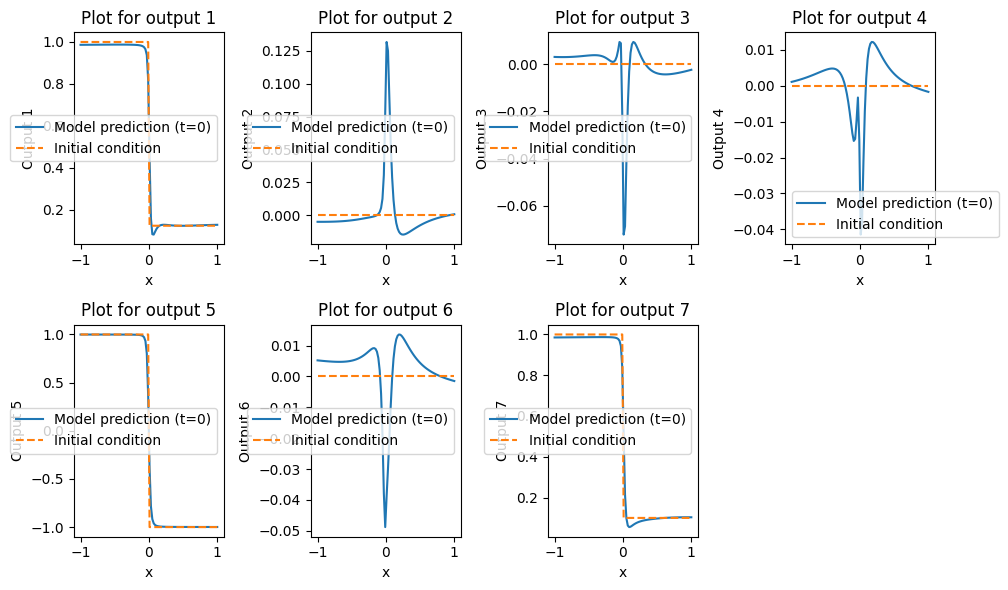

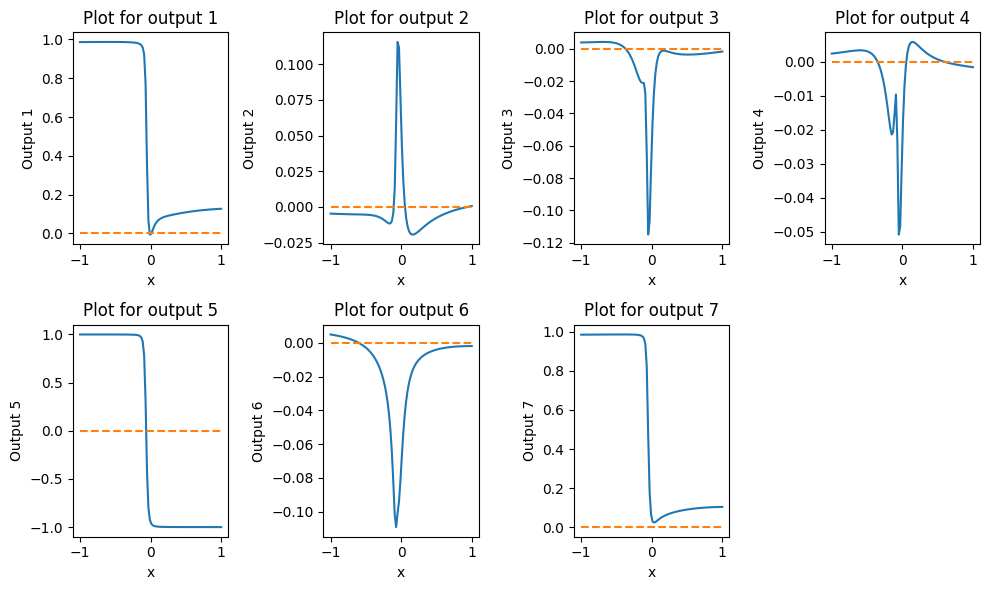

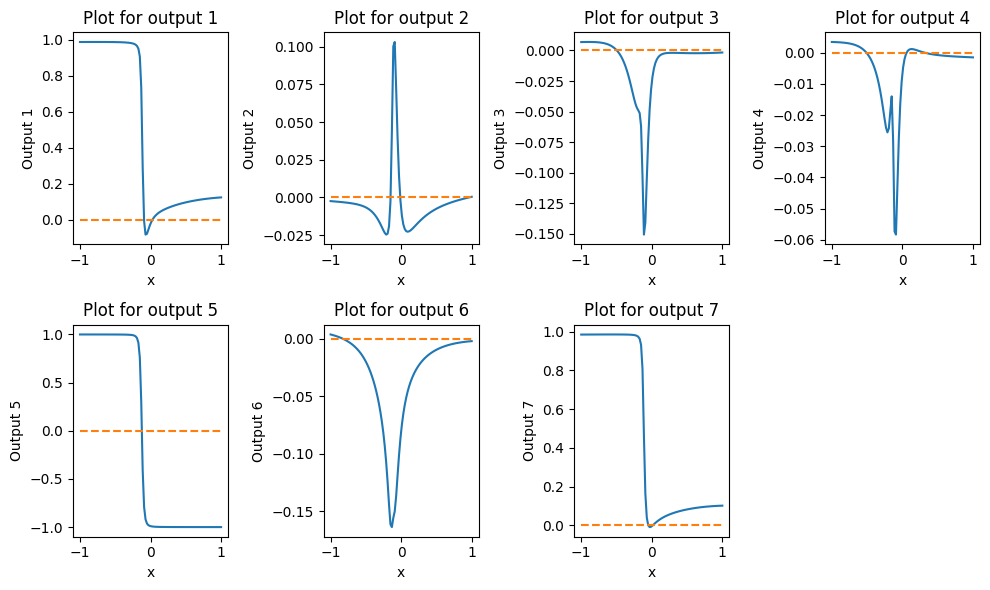

In [25]:
# Corwin's plotting function


model = loaded_model #if plotting the loaded model


model.eval()

# Corwin's plotting function

def plot_at_time(t, x_range=[-1, 1], num_points=100):
    """
    Plots the model prediction and initial condition at a given time t.

    Parameters:
        t (float): The time at which to evaluate the model and initial condition.
        x_range (list, optional): Range over which to evaluate x. Defaults to [-1, 1].
        num_points (int, optional): Number of points to evaluate in x_range. Defaults to 100.
    """
    x = torch.linspace(x_range[0], x_range[1], num_points).view(-1, 1)
    t_tensor = torch.full_like(x, t)

    x.requires_grad = True
    t_tensor.requires_grad = True
    
    preds = model(t_tensor, x).detach().numpy()
    
    if t == 0:
        initial_conds = initial_condition(x).detach().numpy()
    else:
        initial_conds = np.zeros_like(preds)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    x_numpy = x.detach().numpy()


    for i in range(preds.shape[1]):
        plt.subplot(2, 4, i+1)
        plt.plot(x_numpy, preds[:, i], label=f"Model prediction (t={t})")
        plt.plot(x_numpy, initial_conds[:, i], label="Initial condition" if t==0 else "", linestyle='--')
        plt.title(f"Plot for output {i+1}")
        plt.xlabel("x")
        plt.ylabel(f"Output {i+1}")
        if t == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_at_time(0)  # Plot model prediction and initial condition at t=0
plot_at_time(0.5)  # Plot model prediction at t=0.5
plot_at_time(1)  # Plot model prediction at t=1


### Loss Function

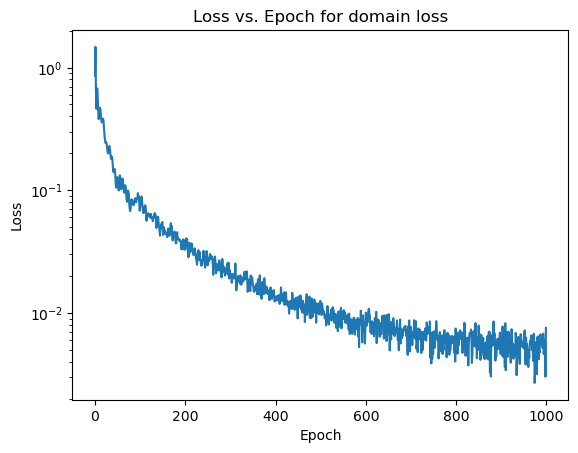

In [243]:
# Plot the loss history
# make sure converges to smaller loss
plt.figure()
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch for domain loss')
plt.show()

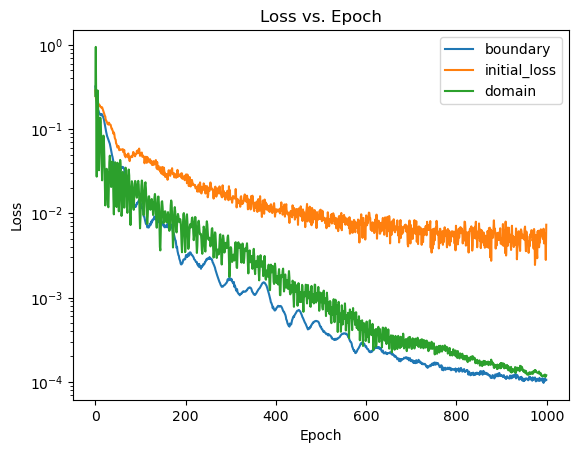

In [244]:
# Plot the loss history
plt.figure()
plt.plot(range(len(boundary_loss_history)), boundary_loss_history, label = "boundary")
plt.plot(range(len(boundary_loss_history)), initial_loss_history, label = "initial_loss")
plt.plot(range(len(boundary_loss_history)), domain_loss_history, label = "domain")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch')
plt.show()

#### Check gradient similarity

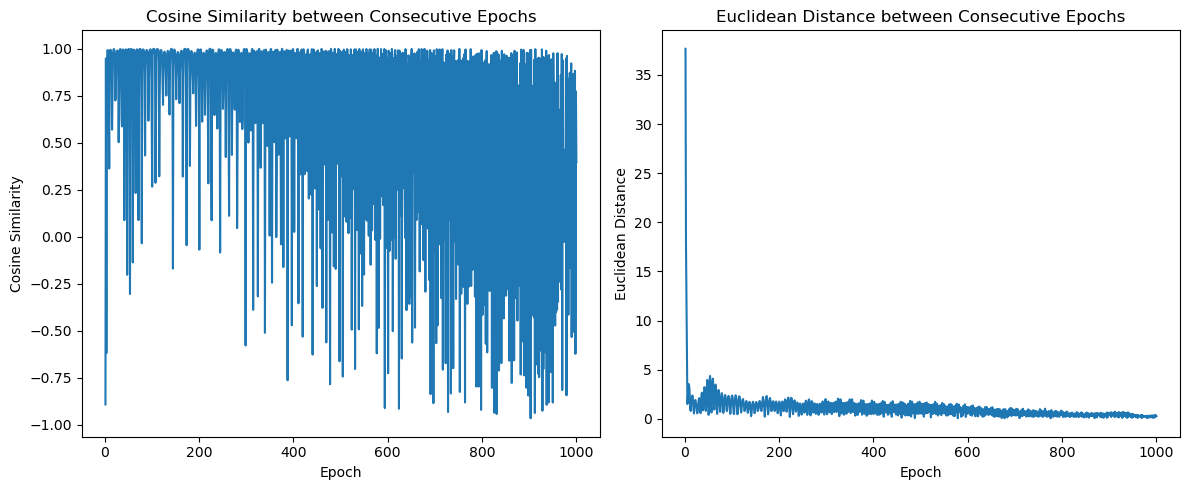

In [245]:
cosine_similarities = []
euclidean_distances = []

for i in range(1, len(gradient_history)):
    cos_sim, euc_dist = calculate_similarity_metrics(gradient_history[i], gradient_history[i-1])
    cosine_similarities.append(cos_sim)
    euclidean_distances.append(euc_dist)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, len(gradient_history) + 1), cosine_similarities)
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Consecutive Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(2, len(gradient_history) + 1), euclidean_distances)
plt.xlabel('Epoch')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance between Consecutive Epochs')

plt.tight_layout()
plt.show()

### Initial Condition

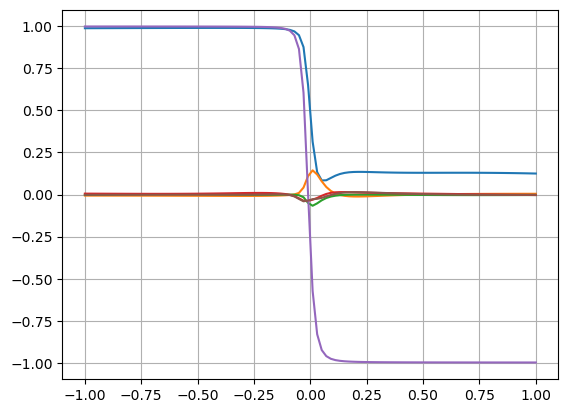

In [269]:
model.eval()

x = np.linspace(-1, 1, 100)
t = np.array([0])

t, x = np.meshgrid(t, x)
t, x = t.flatten(), x.flatten()
t, x = torch.Tensor(t), torch.Tensor(x)
prediction = model(t, x).detach()
prediction = prediction.reshape(100,7)
for i in range(0,6):
    
#plt.imshow(prediction)
    
    plt.plot(x.numpy(), prediction[:,i].flatten().numpy())
    plt.grid(True)
plt.show()

In [273]:
# pcolormesh
model.eval()

x = np.linspace(-1, 1, 100)
t = np.array([0])

t, x = np.meshgrid(t, x)
t, x = t.flatten(), x.flatten()
t, x = torch.Tensor(t), torch.Tensor(x)
prediction = model(t, x).detach()
prediction = prediction.reshape(100,7)
for i in range(0,6):
    
#plt.imshow(prediction)
    
#     plt.plot(x.numpy(), prediction[:,i].flatten().numpy())
    np.pcolormesh(time, x, predictions[o])
    plt.grid(True)
plt.show()


AttributeError: module 'numpy' has no attribute 'pcolormesh'

In [247]:
model.eval()

x = np.linspace(-1, 1, 100)
t = np.linspace(0, 0, 1)

t, x = np.meshgrid(t, x)
t, x = t.flatten(), x.flatten()
t, x = torch.Tensor(t), torch.Tensor(x)
prediction = model(t, x).detach()
prediction = prediction.reshape(100, 7)

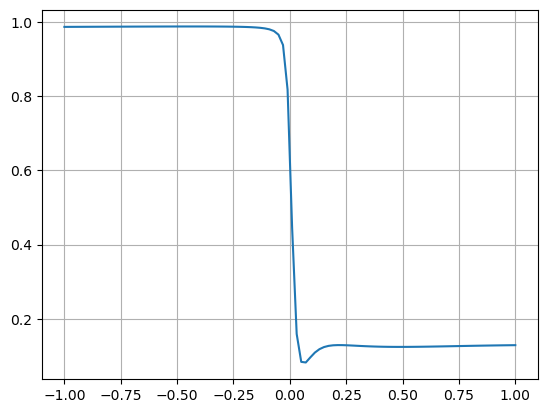

In [280]:
model.eval()

x = np.linspace(-1, 1, 100)
t = np.linspace(0, 0, 1)

t, x = np.meshgrid(t, x)
t, x = t.flatten(), x.flatten()
t, x = torch.Tensor(t), torch.Tensor(x)
prediction = model(t, x).detach()
prediction = prediction.reshape(100, 7)

#plt.imshow(prediction)

plt.plot(x.numpy(), prediction[:,0].flatten().numpy())
plt.grid(True)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=10bedb5b-3713-4aa3-bd35-83eed005533b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>